In [147]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [148]:
pip install mysql-connector-python


In [149]:
pip install geopandas


Note: you may need to restart the kernel to use updated packages.


In [150]:
pip install folium


Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install selenium pillow


Note: you may need to restart the kernel to use updated packages.


Step 1: Data Loading and Cleaning

In [152]:
crime_data =pd.read_excel("E:\\DATA_Engineering_lab\\china_crime_sample_data_1000.xlsx")
crime_data 

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00,63,30,Unknown,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01,47,59,Unknown,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02,57,20,Unknown,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05,68,29,NaN,23.120373,116.131223
...,...,...,...,...,...,...,...,...,...,...
995,1996,Fraud,Chengdu,2024-12-29,23:53,18,61,Unknown,21.831641,113.139103
996,1997,Vandalism,Xi'an,2024-12-29,23:54,37,57,Unknown,38.346272,119.132292
997,1998,Assault,Guangzhou,2024-12-30,23:56,39,35,NaN,22.736373,101.379160
998,1999,Fraud,Guangzhou,2024-12-30,23:57,65,51,NaN,39.004747,101.141094


In [153]:
crime_data .head()

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00,63,30,Unknown,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01,47,59,Unknown,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02,57,20,Unknown,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05,68,29,NaN,23.120373,116.131223


In [154]:
crime_data.tail()

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
995,1996,Fraud,Chengdu,2024-12-29,23:53,18,61,Unknown,21.831641,113.139103
996,1997,Vandalism,Xi'an,2024-12-29,23:54,37,57,Unknown,38.346272,119.132292
997,1998,Assault,Guangzhou,2024-12-30,23:56,39,35,NaN,22.736373,101.379160
998,1999,Fraud,Guangzhou,2024-12-30,23:57,65,51,NaN,39.004747,101.141094
999,2000,Burglary,Chengdu,2024-12-31,23:59,28,42,NaN,28.920115,105.643741


In [155]:
# Clean the data (example: filling missing values)
crime_data.fillna(method='ffill', inplace=True)

C:\Users\manis\AppData\Local\Temp\ipykernel_3792\283061638.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crime_data.fillna(method='ffill', inplace=True)


In [156]:
crime_data.isnull().sum()

Crime_ID       0
Crime_Type     0
Location       0
Date           0
Time           0
Victim_Age     0
Suspect_Age    0
Weapon_Used    0
Latitude       0
Longitude      0
dtype: int64

In [157]:
# Check for missing values
print("Missing values:\n", crime_data.isnull().sum())

# Fill or drop missing values based on relevance
crime_data = crime_data.dropna()  # Optionally fill with mean or median values based on context

# Convert Date and Time columns to proper datetime format
crime_data['Date'] = pd.to_datetime(crime_data['Date'], format='%Y-%m-%d')
crime_data['Time'] = pd.to_datetime(crime_data['Time'], format='%H:%M').dt.time

# Remove duplicate rows, if any
df = crime_data.drop_duplicates()

# Verify data types
print("Data types:\n", df.dtypes)

Missing values:
 Crime_ID       0
Crime_Type     0
Location       0
Date           0
Time           0
Victim_Age     0
Suspect_Age    0
Weapon_Used    0
Latitude       0
Longitude      0
dtype: int64
Data types:
 Crime_ID                int64
Crime_Type             object
Location               object
Date           datetime64[ns]
Time                   object
Victim_Age              int64
Suspect_Age             int64
Weapon_Used            object
Latitude              float64
Longitude             float64
dtype: object


Step 2: Exploratory Data Analysis (EDA)

          Crime_ID                        Date   Victim_Age  Suspect_Age  \
count  1000.000000                        1000  1000.000000  1000.000000   
mean   1500.500000  2024-07-01 00:01:26.400000    43.582000    43.964000   
min    1001.000000         2024-01-01 00:00:00    18.000000    18.000000   
25%    1250.750000         2024-03-31 18:00:00    31.000000    31.000000   
50%    1500.500000         2024-07-01 00:00:00    43.000000    43.000000   
75%    1750.250000         2024-09-30 06:00:00    57.000000    57.000000   
max    2000.000000         2024-12-31 00:00:00    69.000000    69.000000   
std     288.819436                         NaN    14.778555    14.783411   

          Latitude    Longitude  
count  1000.000000  1000.000000  
mean     29.805131   110.140346  
min      20.092640   100.064365  
25%      24.719465   104.821485  
50%      29.936148   110.374678  
75%      34.886392   115.209301  
max      39.994353   119.988275  
std       5.842747     5.843798  


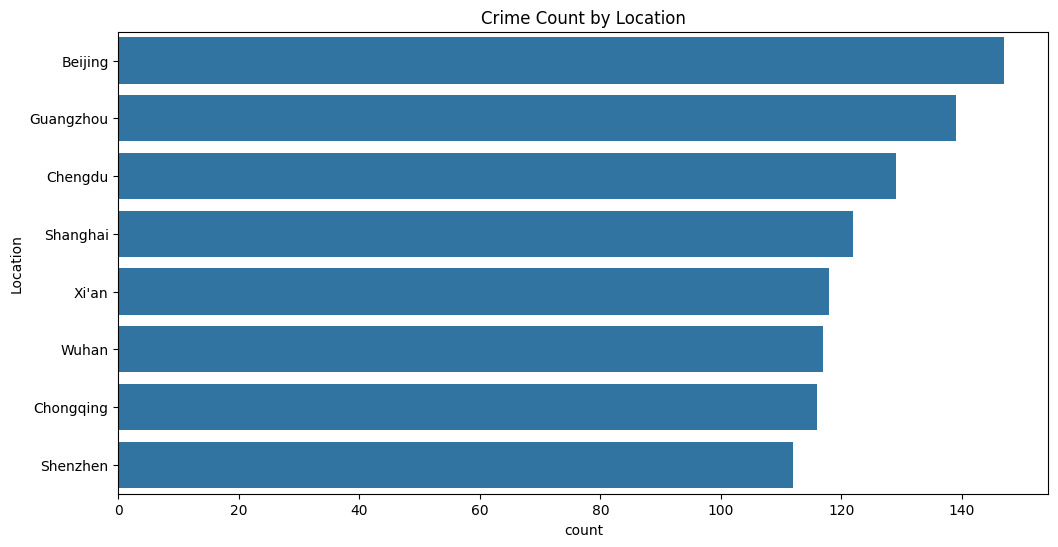

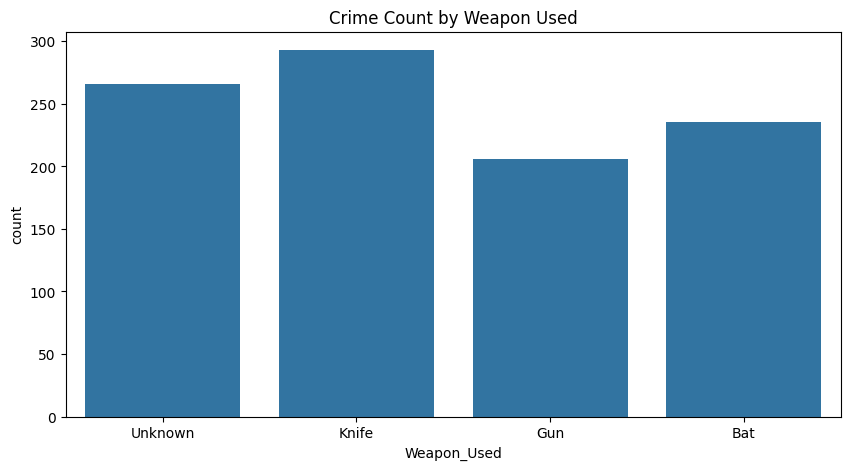

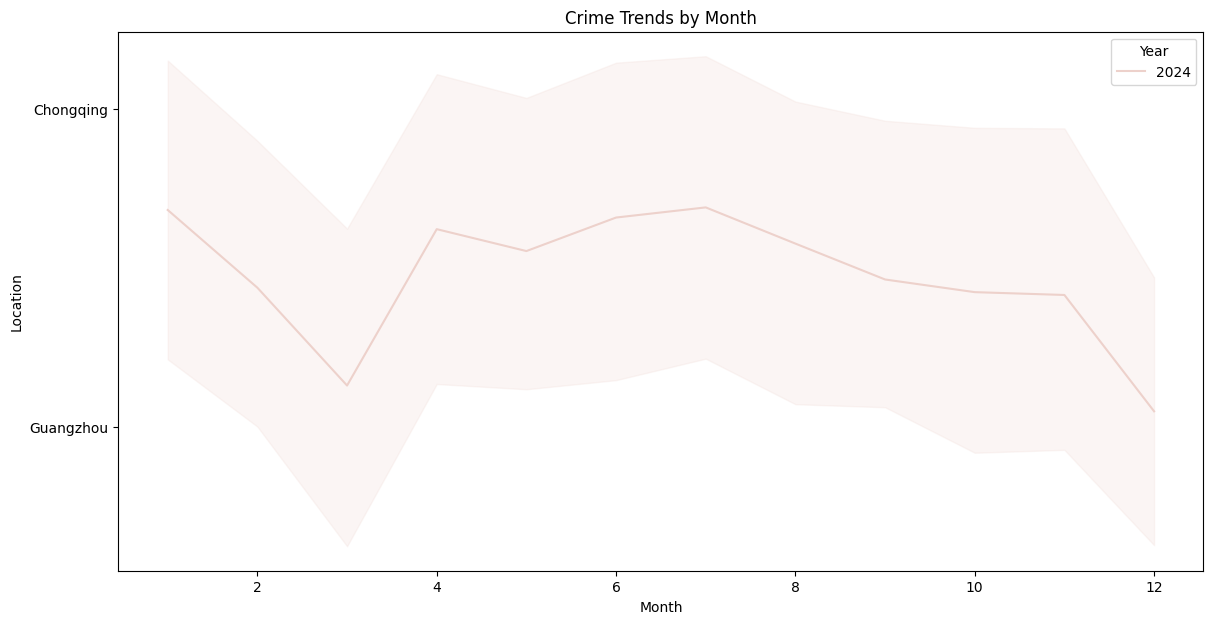

In [158]:
# Basic statistics
print(crime_data.describe())

# Crime count by Location
plt.figure(figsize=(12, 6))
sns.countplot(y='Location', data=crime_data, order=crime_data['Location'].value_counts().index)
plt.title('Crime Count by Location')
plt.show()

# Distribution of crime types (assuming Weapon_Used indicates crime types)
plt.figure(figsize=(10, 5))
sns.countplot(x='Weapon_Used', data=crime_data)
plt.title('Crime Count by Weapon Used')
plt.show()

# Crime trends over time
plt.figure(figsize=(14, 7))
crime_data['Year'] = crime_data['Date'].dt.year
crime_data['Month'] = crime_data['Date'].dt.month
sns.lineplot(x='Month', y='Location', data=crime_data, hue='Year')
plt.title('Crime Trends by Month')
plt.show()

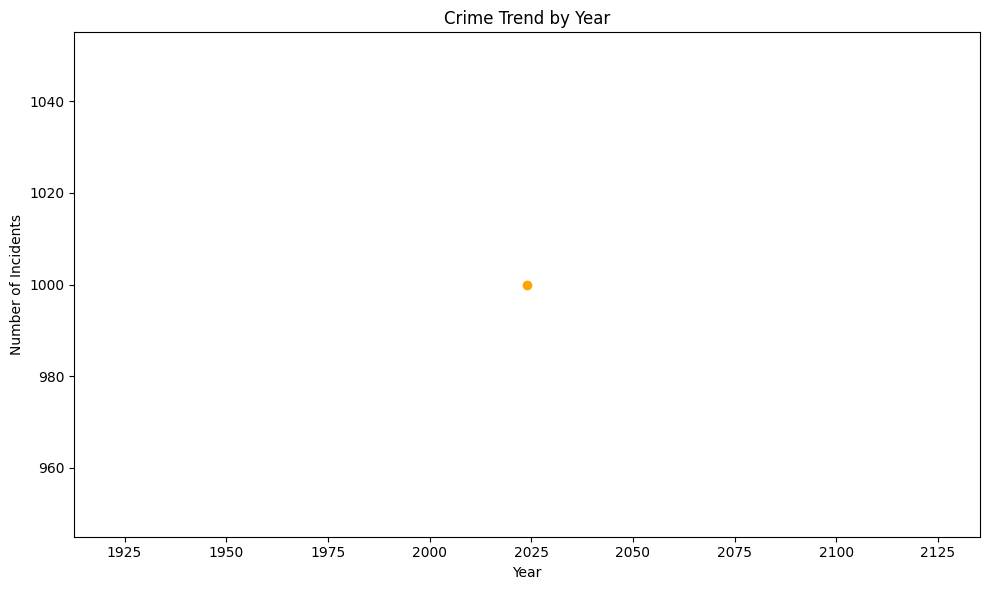

In [159]:


# Convert 'Date' column to datetime
crime_data['Date'] = pd.to_datetime(crime_data['Date'])

# Crime trend by year
crime_trend = crime_data.groupby(crime_data['Date'].dt.year)['Crime_Type'].count()

# Plotting the crime trend over the years
plt.figure(figsize=(10, 6))
crime_trend.plot(kind='line', marker='o', color='orange', title='Crime Trend by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

Step 3: Geospatial Analysis (Using GeoPandas)

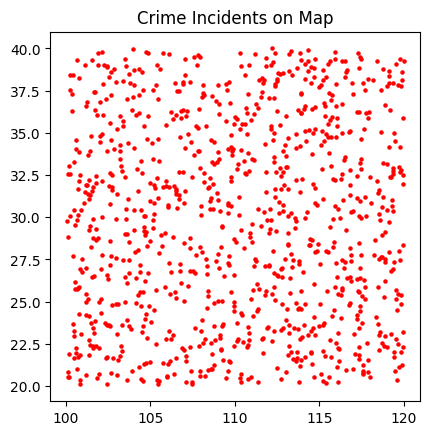

In [160]:
# Create a GeoDataFrame using Latitude and Longitude
gdf = gpd.GeoDataFrame(crime_data, geometry=gpd.points_from_xy(crime_data.Longitude, crime_data.Latitude))

# Plot crime incidents on the map
ax = gdf.plot(marker='o', color='red', markersize=5)
ax.set_title('Crime Incidents on Map')  # Set the title using matplotlib

plt.show()


In [164]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the Excel file using pandas
df = pd.read_excel(r"E:\\DATA_Engineering_lab\\china_crime_sample_data_1000.xlsx")

# Check the data
print(df.head())  # Ensure you have 'Longitude' and 'Latitude' columns in your data

# Create a GeoDataFrame using the latitude and longitude
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Now you can work with the GeoDataFrame `geo_df` to plot or analyze the data


   Crime_ID Crime_Type   Location        Date   Time  Victim_Age  Suspect_Age  \
0      1001   Burglary   Shenzhen  2024-01-01  00:00          63           30   
1      1002      Fraud      Wuhan  2024-01-01  00:01          47           59   
2      1003   Burglary    Beijing  2024-01-01  00:02          57           20   
3      1004    Assault  Chongqing  2024-01-02  00:04          35           26   
4      1005    Assault   Shenzhen  2024-01-02  00:05          68           29   

  Weapon_Used   Latitude   Longitude  
0     Unknown  27.490802  103.702659  
1     Unknown  39.014286  110.838019  
2     Unknown  34.639879  117.458917  
3       Knife  31.973170  114.644498  
4         NaN  23.120373  116.131223  


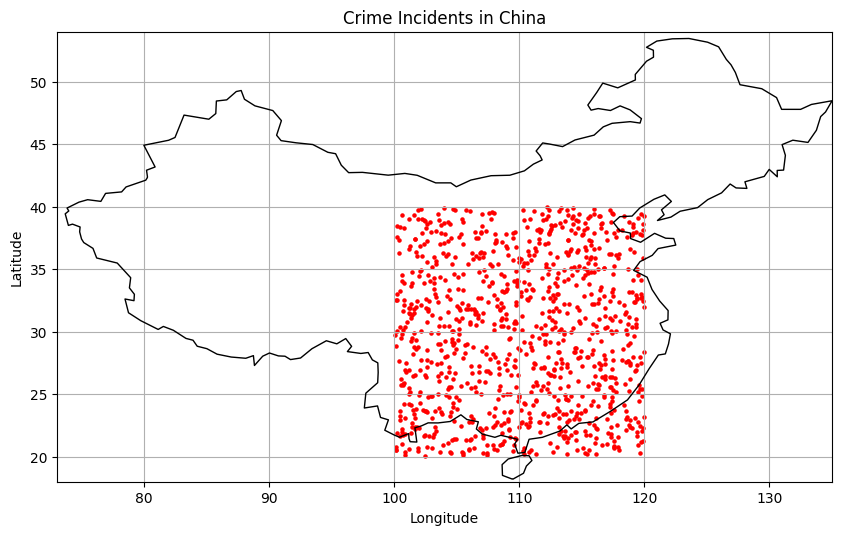

In [167]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Load the shapefile of the world map (ensure to specify the correct path)
shapefile_path = r"E:\DATA_Engineering_lab\ne_110m_admin_0_countries"
world = gpd.read_file(shapefile_path)

# Filter to get only China
china = world[world['ADMIN'] == 'China']

# Create the plot for crime incidents
fig, ax = plt.subplots(figsize=(10, 10))
china.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot China boundaries
geo_df.plot(ax=ax, color='red', markersize=5)           # Plot crime incidents

# Set titles and labels
plt.title('Crime Incidents in China')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(73, 135)  # Approximate longitude bounds of China
plt.ylim(18, 54)   # Approximate latitude bounds of China
plt.grid()
plt.show()

# Create a map using folium
m = folium.Map(location=[35.0, 105.0], zoom_start=5)

# Define color mapping for different crime types
crime_colors = {
    'Theft': 'blue',
    'Assault': 'red',
    'Burglary': 'green',
    'Fraud': 'purple',
    'Vandalism': 'orange',
    # Add more crime types and colors as needed
}

# Calculate the total number of incidents
total_incidents = len(crime_data)

# Calculate the crime rates
crime_rate = crime_data['Crime_Type'].value_counts(normalize=True) * 100  # in percentage

# Add markers for each crime incident
for index, row in crime_data.iterrows():
    crime_type = row['Crime_Type']
    crime_rate_value = crime_rate[crime_type] if crime_type in crime_rate else 0.0  # Default to 0 if not found
    color = crime_colors.get(crime_type, 'gray')  # Default to gray if crime type not found

    # Create a marker with a tooltip
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Crime Type: {crime_type}<br>Crime Rate: {crime_rate_value:.2f}%",
        icon=folium.Icon(color=color)
    ).add_to(m)

# Save the map to an HTML file
m.save('crime_locations_map_with_rates.html')

# Display the map (if you're in a


Clustering and Predictive Modeling

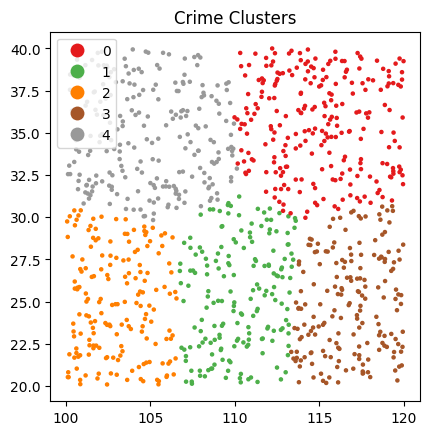

In [130]:
# Prepare data for clustering
coordinates = crime_data[['Latitude', 'Longitude']].dropna()

# Apply K-Means clustering to find patterns in crime locations
kmeans = KMeans(n_clusters=5)
crime_data['Cluster'] = kmeans.fit_predict(coordinates)

# Ensure 'gdf' is a GeoDataFrame with 'geometry' column containing geometries from the coordinates
gdf = gpd.GeoDataFrame(crime_data, geometry=gpd.points_from_xy(crime_data['Longitude'], crime_data['Latitude']))

# Visualize the clusters on a map
gdf['Cluster'] = crime_data['Cluster']
gdf.plot(column='Cluster', categorical=True, legend=True, markersize=5, cmap='Set1')

# Set the title using Matplotlib
plt.title('Crime Clusters')
plt.show()


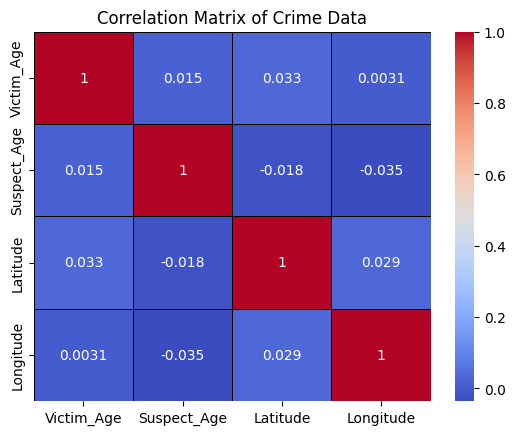

In [131]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is already in a DataFrame called 'df'
# Check correlation between numeric fields
corr = df[['Victim_Age', 'Suspect_Age', 'Latitude', 'Longitude']].corr()

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')

# Add a title to the heatmap
plt.title('Correlation Matrix of Crime Data')

# Display the plot
plt.show()


Predictive Model (Logistic Regression)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare features and labels for modeling
X = crime_data[['Victim_Age', 'Suspect_Age', 'Latitude', 'Longitude']]
y = crime_data['Crime_Type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Display classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     Assault       0.16      0.11      0.13        53
    Burglary       0.24      0.30      0.27        63
       Fraud       0.10      0.03      0.05        64
       Theft       0.14      0.11      0.12        66
   Vandalism       0.19      0.39      0.25        54

    accuracy                           0.18       300
   macro avg       0.16      0.19      0.16       300
weighted avg       0.16      0.18      0.16       300



Exploring Crime Types, Location, Time, Victim, and Suspect Profiles

In [133]:
# Print the column names to check for discrepancies
print(crime_data.columns)


Index(['Crime_ID', 'Crime_Type', 'Location', 'Date', 'Time', 'Victim_Age',
       'Suspect_Age', 'Weapon_Used', 'Latitude', 'Longitude', 'Year', 'Month',
       'Cluster'],
      dtype='object')


In [134]:
# Exploring types of crime
print(crime_data['Crime_Type'].value_counts())  # Adjusted to the correct column name


Crime_Type
Burglary     213
Theft        209
Fraud        203
Vandalism    200
Assault      175
Name: count, dtype: int64


In [135]:
# Clean column names by stripping whitespace and converting to lowercase
crime_data.columns = crime_data.columns.str.strip().str.lower()

# Now you can access columns with lower case names
print(crime_data['crime_type'].value_counts())



crime_type
Burglary     213
Theft        209
Fraud        203
Vandalism    200
Assault      175
Name: count, dtype: int64


In [136]:
# Analyzing crime locations
print(crime_data['location'].value_counts())


location
Beijing      147
Guangzhou    139
Chengdu      129
Shanghai     122
Xi'an        118
Wuhan        117
Chongqing    116
Shenzhen     112
Name: count, dtype: int64


In [137]:
# Check the data types of the relevant columns
print(crime_data[['date', 'time']].dtypes)


date    datetime64[ns]
time            object
dtype: object


In [138]:
# Convert 'date' to string if it's not already
if not pd.api.types.is_string_dtype(crime_data['date']):
    crime_data['date'] = crime_data['date'].dt.strftime('%Y-%m-%d')  # Adjust format as needed

# Convert 'time' to string if it's not already
if not pd.api.types.is_string_dtype(crime_data['time']):
    crime_data['time'] = crime_data['time'].astype(str)  # Convert to string


In [139]:
# Combine date and time into a single datetime column
crime_data['datetime'] = pd.to_datetime(crime_data['date'] + ' ' + crime_data['time'])

# Extract year and month
crime_data['year'] = crime_data['datetime'].dt.year
crime_data['month'] = crime_data['datetime'].dt.month


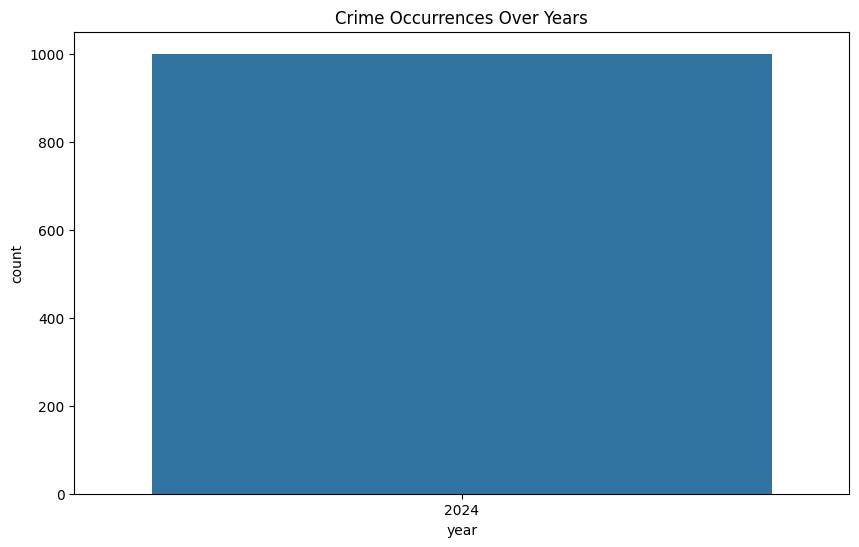

   victim_age  suspect_age
0          63           30
1          47           59
2          57           20
3          35           26
4          68           29


In [140]:
# Plotting crime occurrences over time
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=crime_data)
plt.title('Crime Occurrences Over Years')
plt.show()

# Analyzing victim and suspect profiles
print(crime_data[['victim_age', 'suspect_age']].dropna().head())

In [141]:
import geopandas as gpd
import folium
from folium.plugins import HeatMap

# Assuming the dataset has 'latitude' and 'longitude' columns for locations
crime_data_cleaned = crime_data.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(crime_data_cleaned, geometry=gpd.points_from_xy(crime_data_cleaned.longitude, crime_data_cleaned.latitude))

# Create a heatmap
crime_map = folium.Map(location=[gdf['latitude'].mean(), gdf['longitude'].mean()], zoom_start=12)

# Add points to the map
heat_data = [[row['latitude'], row['longitude']] for index, row in crime_data_cleaned.iterrows()]
HeatMap(heat_data).add_to(crime_map)

# Display the map
crime_map.save('crime_heatmap.html')


Using Heatmaps for Crime Hotspots

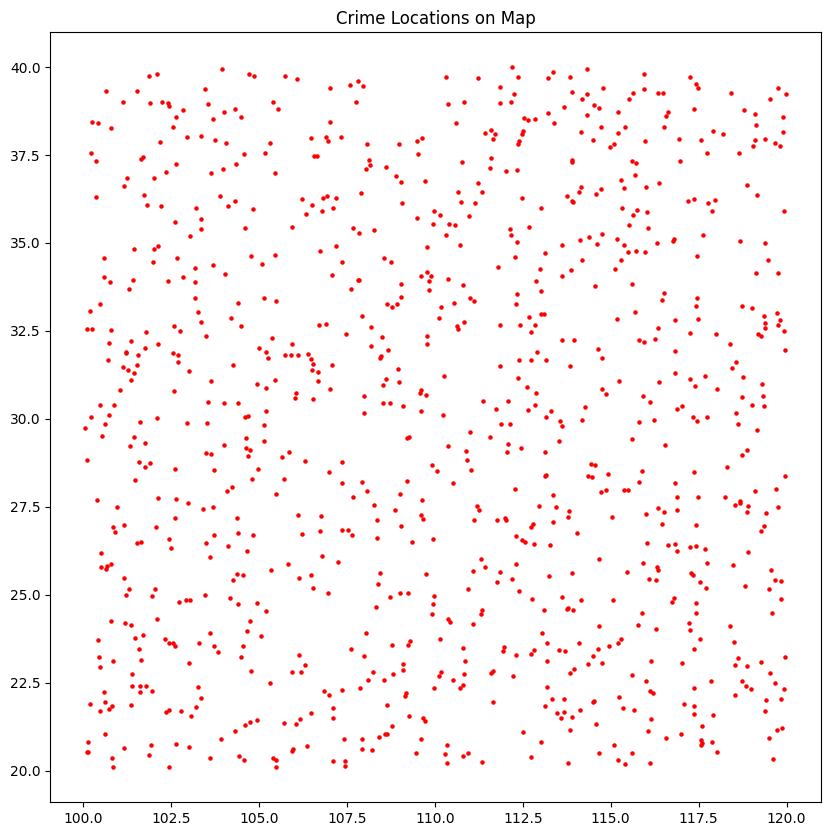

In [142]:
# Plotting the geographical distribution of crimes
gdf.plot(marker='o', color='red', markersize=5, figsize=(10, 10))
plt.title("Crime Locations on Map")
plt.show()


Mapping Geographic Data with GeoPandas

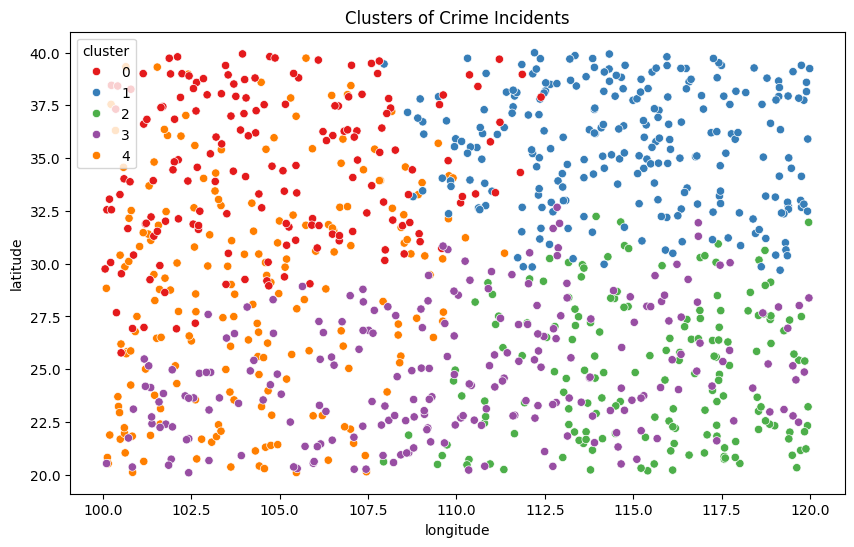

In [143]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering (e.g., location and time of crime)
features = crime_data_cleaned[['latitude', 'longitude', 'month', 'year']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_scaled)
crime_data_cleaned['cluster'] = kmeans.labels_

# Visualizing clusters on the map
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=crime_data_cleaned, palette='Set1')
plt.title('Clusters of Crime Incidents')
plt.show()


In [144]:
# Assuming the dataset has 'latitude' and 'longitude' columns for locations
crime_data_cleaned = crime_data_cleaned.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(crime_data_cleaned, geometry=gpd.points_from_xy(crime_data_cleaned.longitude, crime_data_cleaned.latitude))

# Create a heatmap
crime_map = folium.Map(location=[gdf['latitude'].mean(), gdf['longitude'].mean()], zoom_start=12)

# Add points to the map
heat_data = [[row['latitude'], row['longitude']] for index, row in crime_data_cleaned.iterrows()]
HeatMap(heat_data).add_to(crime_map)

# Display the map
crime_map.save('crime_heatmap.html')

In [145]:
import folium
from folium.plugins import HeatMap
from selenium import webdriver
from PIL import Image

# Assuming the dataset has 'latitude' and 'longitude' columns for locations
crime_data_cleaned = crime_data_cleaned.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(crime_data_cleaned, geometry=gpd.points_from_xy(crime_data_cleaned.longitude, crime_data_cleaned.latitude))

# Create a heatmap
crime_map = folium.Map(location=[gdf['latitude'].mean(), gdf['longitude'].mean()], zoom_start=12)

# Add points to the map
heat_data = [[row['latitude'], row['longitude']] for index, row in crime_data_cleaned.iterrows()]
HeatMap(heat_data).add_to(crime_map)

# Save the map as an HTML file
map_file = 'crime_heatmap.html'
crime_map.save(map_file)

# Use Selenium to open the map in a browser and save a screenshot
browser = webdriver.Chrome()  # Ensure you have a ChromeDriver installed and configured
browser.get('file:///' + map_file)

# Take a screenshot and save it as an image
browser.save_screenshot('crime_heatmap.png')

# Close the browser
browser.quit()

# Open the saved screenshot and save as other formats using Pillow (optional)
img = Image.open('crime_heatmap.png')
img.save('crime_heatmap.jpg', 'JPEG')  # Save as JPEG
img.save('crime_heatmap.pdf', 'PDF')   # Save as PDF
